In [ ]:
import os
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
import wave
import matplotlib.pyplot as plt
import traceback
from glob import glob

In [24]:
# Paths
base = "./Dataset"
train_dir = os.path.join(base, "Training")
val_dir   = os.path.join(base, "Validation")
test_dir  = os.path.join(base, "Testing")


def load_split(split_dir, sr=22050, duration=None, mono=True):

    X, labels = [], []
    classes = sorted(d for d in os.listdir(split_dir)
                     if os.path.isdir(os.path.join(split_dir, d)))
    for cls in classes:
        cls_path = os.path.join(split_dir, cls)
        for fname in os.listdir(cls_path):
            if not fname.lower().endswith(('.wav')):
                continue
            path = os.path.join(cls_path, fname)
            sig, _ = librosa.load(path, sr=sr, mono=mono, duration=duration)
            if duration is not None:
                target_len = int(sr * duration)
                if len(sig) < target_len:
                    sig = np.pad(sig, (0, target_len - len(sig)), 'constant')
                else:
                    sig = sig[:target_len]
            X.append(sig)
            labels.append(cls)
    return np.stack(X), labels



X_train, y_train_labels = load_split(train_dir, sr=16000, duration=3.0)
X_val,   y_val_labels   = load_split(val_dir,   sr=16000, duration=3.0)
X_test,  y_test_labels  = load_split(test_dir,  sr=16000, duration=3.0)

# Label Encoding 
le = LabelEncoder().fit(y_train_labels)
y_train = le.transform(y_train_labels)
y_val   = le.transform(y_val_labels)
y_test  = le.transform(y_test_labels)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)
print("Classes:", le.classes_)


Train: (10644, 48000) (10644,)
Val:   (2662, 48000) (2662,)
Test:  (3014, 48000) (3014,)
Classes: ['deepfake' 'real']


--- WAV File Metadata ---
Number of channels: 1
Sample width: 2 bytes (16-bit)
Frame rate (Sample rate): 16000 Hz
Number of frames: 24280
Duration: 1.52 seconds
-------------------------


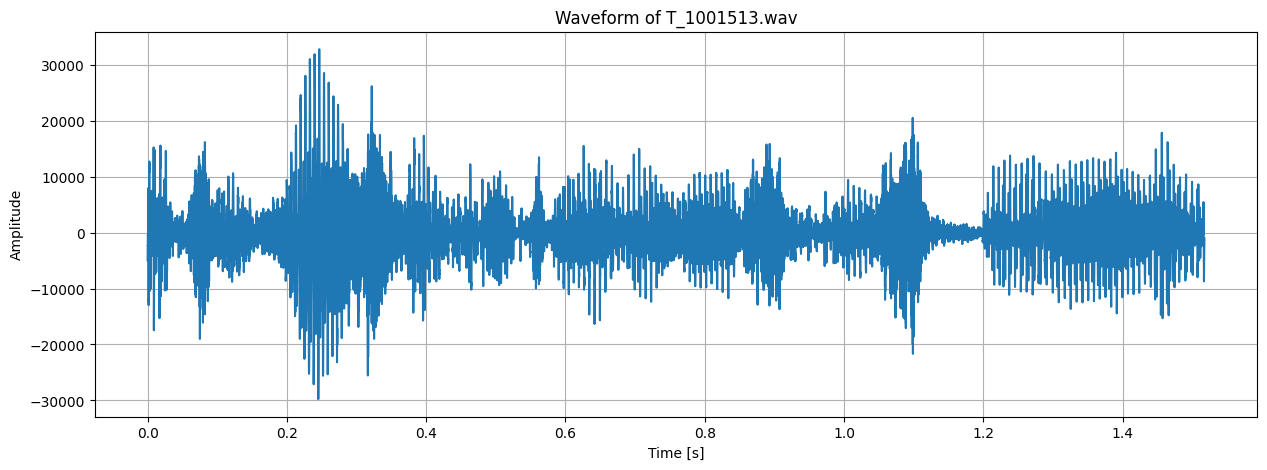

In [ ]:
def analyze_and_plot_wav(file_path):
    try:
        with wave.open(file_path, 'rb') as wf:
            # Get meta data
            num_channels = wf.getnchannels()
            sample_width = wf.getsampwidth()  # Bytes / sample
            frame_rate = wf.getframerate()    # Samples / second
            num_frames = wf.getnframes()      # Total samples per channel
            duration = num_frames / float(frame_rate) # Duration

            print("--- WAV File Metadata ---")
            print(f"Number of channels: {num_channels}")
            print(f"Sample width: {sample_width} bytes ({sample_width * 8}-bit)")
            print(f"Frame rate (Sample rate): {frame_rate} Hz")
            print(f"Number of frames: {num_frames}")
            print(f"Duration: {duration:.2f} seconds")
        
            print("-" * 25)

            
            raw_data = wf.readframes(num_frames)
            
           
         
            if sample_width == 2:
                dtype = np.int16  # 16-bit signed
                
                signal = np.frombuffer(raw_data, dtype=dtype)
            elif sample_width != 2:
                 print("Warning: 24-bit audio plotting might be inaccurate.")
                 
                 padded_data = bytearray()
                 
                 for i in range(0, len(raw_data), 3):
                     
                     sign_byte = b'\x00' if raw_data[i+2] < 128 else b'\xff'
                     padded_data.extend(raw_data[i:i+3])
                     padded_data.extend(sign_byte)
                 dtype = np.int32
                 signal = np.frombuffer(bytes(padded_data), dtype=dtype) / 256 # Scale down
                

            else:
                print(f"Error: Unsupported sample width: {sample_width}")
                return

        
            if num_channels > 1:
                # Ensure the total number of data points matches num_frames * num_channels
                expected_length = num_frames * num_channels
                if len(signal) != expected_length:
                     print(f"Warning: Signal length ({len(signal)}) does not match expected length ({expected_length}). Truncating or padding might occur.")
                     # Adjust num_frames if necessary (e.g., due to incomplete last frame read)
                     num_frames = len(signal) // num_channels
                     signal = signal[:num_frames * num_channels] # Truncate to fit

                signal = signal.reshape((num_frames, num_channels))


            # --- Generate Time Axis ---
            # Create an array of time points corresponding to each frame
            time = np.linspace(0., duration, num_frames)

            # --- Plotting ---
            plt.figure(figsize=(15, 5)) # Set figure size

            if num_channels == 1:
                plt.plot(time, signal)
                plt.ylabel("Amplitude")
            else:
                # Plot each channel separately
                for i in range(num_channels):
                    # Access the i-th column for the i-th channel
                    plt.plot(time, signal[:, i], label=f"Channel {i+1}")
                plt.ylabel("Amplitude")
                plt.legend() # Show legend for multiple channels

            plt.xlabel("Time [s]")
            plt.title(f"Waveform of {file_path.split('/')[-1]}") # Use filename in title
            plt.grid(True) # Add grid
            plt.show() # Display the plot

    except wave.Error as e:
        print(f"Error reading WAV file: {e}")
    except FileNotFoundError:
        print(f"Error: File not found: {file_path}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

file_path = '/home/madan005/dev/Deep Learning/Dataset/Testing/deepfake/T_1001513.wav'
analyze_and_plot_wav(file_path)




In [ ]:

def analyze_and_save_spectrogram_image(
    
    file_path,
    output_image_path,
    image_dim=(200, 200),
    nfft=1024,
    noverlap=512
    
    '''Setting | Frequency Detail | Time Detail | Speed
    ------------------------------------------------------
      nfft=256 | Coarser          | Finer       | Faster
     nfft=1024 | Balanced         | Balanced    | Good
     nfft=2048 | Finer            | Coarser     | Slower
     '''
):
    print(f"Processing: {os.path.basename(file_path)}")
    try:
        with wave.open(file_path, 'rb') as wf:
            sample_width = wf.getsampwidth()
            frame_rate = wf.getframerate()
            num_frames = wf.getnframes()

            if sample_width != 2:
                raise ValueError(f"16-bit only. Found {sample_width} bytes.")
         

            raw = wf.readframes(num_frames)

        data = np.frombuffer(raw, dtype=np.int16)
        if data.size == 0:
            print(f"No data in {file_path}")
            return

        target_w_pixels, target_h_pixels = image_dim
        dpi = 100
        fig = plt.figure(figsize=(target_w_pixels / dpi, target_h_pixels / dpi), dpi=dpi)
        ax = fig.add_axes([0, 0, 1, 1])
        ax.axis('off')
        ax.specgram(data, NFFT=nfft, Fs=frame_rate, noverlap=noverlap, scale='dB', cmap='viridis')

        os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
        plt.savefig(output_image_path, dpi=dpi, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        print(f"Saved: {output_image_path}")
    except Exception as e:
        print(f"Error for {file_path}: {e}")
        traceback.print_exc()
    finally:
        plt.close('all')




output_root = './spectrogram_images'
image_dim = (200, 200)

for wav_path in glob(os.path.join(base, '**', '*.wav'), recursive=True):
    try:
        parts = wav_path.split(os.sep)
        if 'Dataset' in parts:
            dataset_idx = parts.index('Dataset')
            split = parts[dataset_idx + 1]
            category = parts[dataset_idx + 2]
        else:
            continue

        base_filename = os.path.splitext(os.path.basename(wav_path))[0]
        new_filename = f"{category}_image_{base_filename}.png"
        save_path = os.path.join(output_root, split, category, new_filename)

        analyze_and_save_spectrogram_image(
            wav_path,
            save_path,
            image_dim=image_dim
        )

    except Exception as e:
        print(f"Failed to process {wav_path}: {e}")


Processing: E_1005338.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1005338.png
Processing: E_1012576.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1012576.png
Processing: E_1006403.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1006403.png
Processing: E_1004041.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1004041.png
Processing: E_1012358.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1012358.png
Processing: E_1001806.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1001806.png
Processing: E_1000655.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1000655.png
Processing: E_1011596.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1011596.png
Processing: E_1000123.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1000123.png
Processing: E_1001691.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1001691.png
Processing: E_1008491.wav
Saved: ./spectrogram_ima

/home/madan005/miniconda3/envs/my_env/lib/python3.11/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Saved: ./spectrogram_images/Validation/real/real_image_E_1002539.png
Processing: E_1011750.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1011750.png
Processing: E_1008998.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1008998.png
Processing: E_1012761.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1012761.png
Processing: E_1012289.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1012289.png
Processing: E_1009471.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1009471.png
Processing: E_1000217.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1000217.png
Processing: E_1009133.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1009133.png
Processing: E_1005947.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1005947.png
Processing: E_1005535.wav
Saved: ./spectrogram_images/Validation/real/real_image_E_1005535.png
Processing: E_1007788.wav
Saved: ./spectrogram_images/Validation/real/real_i